In [ ]:
# === Imports ===
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import statsmodels.api as sm

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

Q1)
I chose the Linear regression model since Cook's distance was designed for OLS regression. I chose Statsmodel OLS because it has a built in influence function so I can easily calculate Cook's distance.

In [ ]:
# === Load dataset ===
DATA_PATH = "usina_with_outliers.csv"
df_outliers = pd.read_csv(DATA_PATH)

# Define IVs and DV
X = df_outliers[['AT', 'V', 'AP', 'RH']]
y = df_outliers['PE']

# Add constant for intercept
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X)
results = model.fit()


Q2)

In [ ]:

# Calculate Cook's distance
influence = results.get_influence()
cooks_distance = influence.cooks_distance[0]

# Define threshold
n = len(df_outliers)
threshold = 4 / n

# Identify outliers
outliers = cooks_distance > threshold
print(f"Number of outliers detected: {outliers.sum()}")

# Remove outliers
df_clean = df_outliers[~outliers]

# Export cleaned dataset
df_clean.to_csv("usina.csv", index=False)

print(f"Original dataset size: {len(df_outliers)}")
print(f"Cleaned dataset size: {len(df_clean)}")
print(f"Removed {len(df_outliers) - len(df_clean)} outliers")


Number of outliers detected: 120
Original dataset size: 9568
Cleaned dataset size: 9448
Removed 120 outliers


Q2)

In [ ]:
def prepare_xy(df_in, out_col):
  # Create a clean DataFrame by dropping rows with any missing values
  df_clean = df_in.dropna().copy()
  X = df_clean.drop(columns=[out_col])
  y = df_clean[out_col]
  return X, y

def split_data(X, y, test_size=0.3, random_state=42):
    # Split the data into training and testing sets
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def compute_metrics(y_true, y_pred):
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    # Calculate R-squared (R^2)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "MAE": mae, "R^2": r2}

def run_models_and_evaluate(df_in, out_col,
                            test_size=0.3, random_state=42, top_k_terms=15):
  # Prepare features (X) and target (y) for modeling
  X, y = prepare_xy(df_in, out_col)
  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = split_data(X, y, test_size, random_state)

  rows = []

  # Define models
  models = [
      ("Linear Regression", LinearRegression()),
      ("Ridge Regression (alpha=0.01)", Ridge(alpha=0.01)),
      ("Ridge Regression (alpha=0.1)", Ridge(alpha=0.1)),
      ("Ridge Regression (alpha=1)", Ridge(alpha=1)),
      ("Ridge Regression (alpha=10)", Ridge(alpha=10)),
      ("Ridge Regression (alpha=100)", Ridge(alpha=100)),
      ("Lasso Regression (alpha=0.01)", Lasso(alpha=0.01)),
      ("Lasso Regression (alpha=0.1)", Lasso(alpha=0.1)),
      ("Lasso Regression (alpha=1)", Lasso(alpha=1)),
      ("Lasso Regression (alpha=10)", Lasso(alpha=10)),
      ("Lasso Regression (alpha=100)", Lasso(alpha=100))
  ]
  for model_name, model in models:

    # Fit model to training data
    model.fit(X_train, y_train)

    # Make predictions on training and test data
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    # Compute evaluation metrics for training and test predictions
    train_m = compute_metrics(y_train, yhat_train)
    test_m = compute_metrics(y_test, yhat_test)

    # Store results for the current model
    rows.append({
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
        })

  # Convert the list of results to a DataFrame and return
  return pd.DataFrame(rows)


In [76]:
print(f"With outliers")
outliers_results = run_models_and_evaluate(df_outliers, "PE")
print(outliers_results)

print(f"Without outliers")
clean_results = run_models_and_evaluate(df_clean, "PE")
print(clean_results)


With outliers
                            Model   Train MSE  Train MAE  Train R^2    Test MSE   Test MAE  Test R^2
0               Linear Regression  123.384207   5.198679   0.650171  125.113389   5.052458  0.642574
1   Ridge Regression (alpha=0.01)  123.384207   5.198679   0.650171  125.113389   5.052458  0.642574
2    Ridge Regression (alpha=0.1)  123.384207   5.198680   0.650171  125.113392   5.052459  0.642574
3      Ridge Regression (alpha=1)  123.384207   5.198685   0.650171  125.113421   5.052463  0.642574
4     Ridge Regression (alpha=10)  123.384207   5.198737   0.650171  125.113705   5.052513  0.642573
5    Ridge Regression (alpha=100)  123.384213   5.199261   0.650171  125.116548   5.053003  0.642565
6   Lasso Regression (alpha=0.01)  123.384210   5.198858   0.650171  125.115332   5.052626  0.642568
7    Lasso Regression (alpha=0.1)  123.384607   5.201739   0.650169  125.134495   5.055348  0.642514
8      Lasso Regression (alpha=1)  123.421151   5.229507   0.650066  125.3383

Discussion: The outliers do change both train and test error. Removin the outliers improves both the train and test error. The test MSE is reduced from 125.11 to 20.40 in the Linear regression model, but improvement can be seen in all the models. With outliers the difference between the test and train MSE is around 0.01. When the outliers are removed the gap is around 0.001. This indicates that the dataset without the outliers has better generalization.

The Ridge regression had only slight performance improvement compared to the linear model with all of the models performing very similarly across all of the chosen alpha values. The Lasso regression performed decently well at lower alpha values but as the alpha increased the performance got significantly worse, especially at alpha = 100.

Q3)
For this problem I chose the Linear regression with Statsmodel. The reliablity of a coefficient is measured by standard errors, t-statistics, p-values, and confidence intervals. The Statsmodel has a built in summary function that shows all of those metrics. The ridge and lasso models would shrink coefficients so I chose the linear regression since it's better at giving unbiased estimates. I also didn't scale the coefficients since it wouldn't change how reliable a coefficient would be.

In [ ]:
df = pd.read_csv('usina.csv')

X = df[['AT', 'V', 'AP', 'RH']]
y = df['PE']

X_with_constant = sm.add_constant(X)

model = sm.OLS(y, X_with_constant)
results = model.fit()

print(results.summary())

most_reliable = results.pvalues.drop('const').idxmin()
least_reliable = results.pvalues.drop('const').idxmax()

print(f"\nThe most reliable coefficient is {most_reliable}")
print(f" - t-statistic: {results.tvalues[most_reliable]:6f}")
print(f" - P-value: {results.pvalues[most_reliable]:6f}")
print(f" - Std. Error: {results.bse[most_reliable]:6f}")

print(f"The least reliable coefficient is {least_reliable}")
print(f" - t-statistic: {results.tvalues[least_reliable]:6f}")
print(f" - P-value: {results.pvalues[least_reliable]:6f}")
print(f" - Std. Error: {results.bse[least_reliable]:6f}")

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 3.188e+04
Date:                Wed, 28 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:04:05   Log-Likelihood:                -27563.
No. Observations:                9448   AIC:                         5.514e+04
Df Residuals:                    9443   BIC:                         5.517e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        440.9993      9.743     45.265      0.0

The reliability of the coefficients was determined using the t-statistic values gotten from the summary function. The AT coefficient had the highest magnitude making it the most reliable and the AP coefficient had the lowest magnitude making it the least reliable.

Q4)
I chose linear regression since its coefficients aren't shrunk at all so they accurately show the impact of each feature. The ridge and lasso regressions shrink the coefficients which makes it harder to see the importance. I chose SKlearn since it's simpler for just linear regression since I don't need the extra functions that Statsmodels has.
I chose to scale the features so they all have the same unit and their magnitudes are directly comparable.

In [77]:
# already had df and X and y

# Scale only the features
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Fit linear regression
model = LinearRegression()
model.fit(X_scaled, y)

# Get the coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_,
    'Abs. Coefficient': np.abs(model.coef_)
})

# Sort
coefficients = coefficients.sort_values(by='Abs. Coefficient', ascending=False)

# Print
print("\n=== Feature Importance ===")
print(coefficients)

print(f"\nThe most important coefficient is {coefficients['Feature'].iloc[0]}")
print(f" - Coefficient: {coefficients['Coefficient'].iloc[0]:6f}")
print(f"The least important coefficient is {coefficients['Feature'].iloc[-1]}")
print(f" - Coefficient: {coefficients['Coefficient'].iloc[-1]:6f}")


=== Feature Importance ===
  Feature  Coefficient  Abs. Coefficient
0      AT   -14.556614         14.556614
1       V    -3.030737          3.030737
3      RH    -2.197120          2.197120
2      AP     0.442513          0.442513

The most important coefficient is AT
 - Coefficient: -14.556614
The least important coefficient is AP
 - Coefficient: 0.442513


Q5)

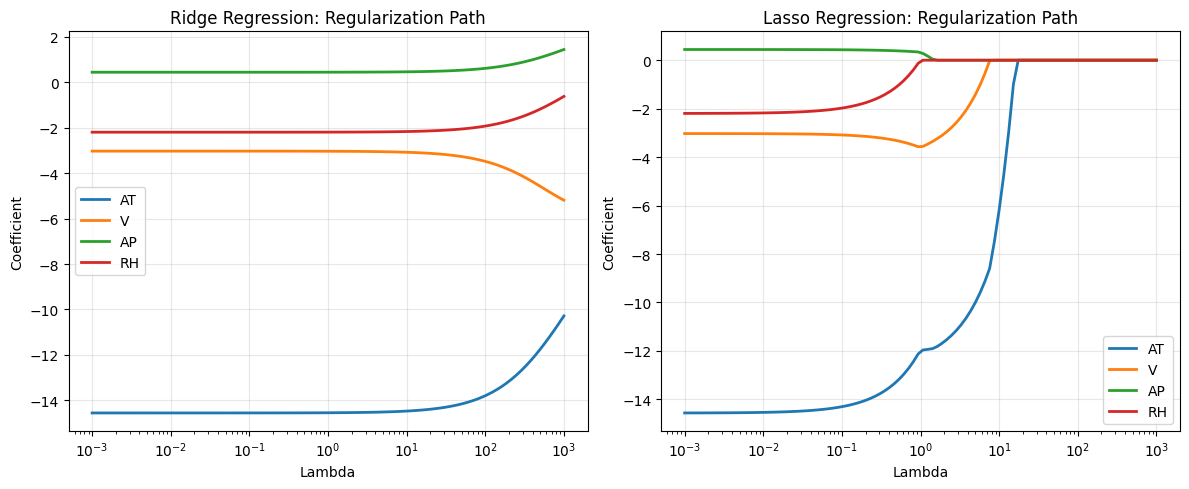

In [ ]:
# Create lambdas
lambdas = np.logspace(-3, 3, 100)

# store coefficients
ridge_coeffs = []
lasso_coeffs = []

# fit ridge
for alpha in lambdas:
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_scaled, y)
  ridge_coeffs.append(ridge.coef_)

for alpha in lambdas:
  lasso = Lasso(alpha=alpha, max_iter=10000)
  lasso.fit(X_scaled, y)
  lasso_coeffs.append(lasso.coef_)

# Convert to array
ridge_coeffs = np.array(ridge_coeffs)
lasso_coeffs = np.array(lasso_coeffs)

# Plot Ridge regularization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, feature in enumerate(X.columns):
    plt.plot(lambdas, ridge_coeffs[:, i], label=feature, linewidth=2)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficient')
plt.title('Ridge Regression: Regularization Path')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Lasso regularization
plt.subplot(1, 2, 2)
for i, feature in enumerate(X.columns):
    plt.plot(lambdas, lasso_coeffs[:, i], label=feature, linewidth=2)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficient')
plt.title('Lasso Regression: Regularization Path')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In the ridge model as the lambda increases, the AT coefficient decreases in magnitude while the other coefficients slightly increase in magnitude. None of them reach zero in the range of 0.001 to 1000. In the lasso model the coefficients behave similarly from lambda = 0.001 to 1 but once lambda > 1 it behaves differently: The AT coefficient quickly decreases, the RH and AP coefficients quickly go to zero and the V coefficient goes to zero as well. At a lambda of around 20 all of the coefficients are zero in the lasso model.

In terms of multicollinearity, the ridge model is better than lasso. This is because lasso arbitrarily selects a variable from a group of correlated featrures and eliminates the others by setting them to zero. This means it's unstable when dealing with multicolliniearity. Ridge on the other hand is able to keep all of the correlated features and shrink them proportionally.

Lasso is better at feature selection because it's much better at shrinking coefficients to zero, leaving the most important features last. Ridge doesn't set any coefficients to zero making it worse at feature selection.